# Tracklist Generator: Tracklist Model
This notebook contains the code for the sequential tracklist generation model. Incorporating and expanding on the modularity-based graph clustering technique described in Tsitsulin et al.'s [Graph Clustering with Graph Neural Networks](https://arxiv.org/abs/2006.16904), the model is trained as a 'Language Model' on the tracklist data scraped from 1001Tracklists, with songs instead of words, using the song/artist embeddings trained in the [Embeddings notebook](2.%20Embeddings.ipynb). The result is a hierarchical clustering of the input songs, and an LSTM which can leverage this clustering information to generate new tracklists.

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score
import time

from dmon import dmon
from dmon import gcn
from dmon import metrics
from dmon import utils
import scipy.sparse
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Concatenate, LSTM, Activation, Embedding, Add, Dot, Multiply, Dropout, BatchNormalization,Flatten
from tensorflow.keras.models import Model,load_model
import tensorflow.keras.backend as K
from typing import Tuple

tf.compat.v1.logging.set_verbosity(40)

## Building the Model
In this section we will describe the architecture of the tracklist model, and implement it as a series of Keras layers. We will train the model in a similar way to how a language model might be trained in a natural language processing task. In the NLP scenario, a model is trained on a corpus of text, with a common training task being the prediction of the next word in a sentence, given the previous words as input. We will train our model using an analogous approach with tracklists: given the previous songs in a tracklist, we want to predict the next song. 

This task is more straightforward than the NLP case, as long-term dependencies are generally a lot less complex in tracklists than they are in natural language. While DJs do manage the energy level and flow of a set across a tracklist, meaning that long-term information is important, there are not likely to be any specific dependencies between tracks which are more than a few songs apart, unlike in the natural language case where, for example, pronoun referents require keeping track of specific information from earlier in a sentence (e.g. '**Jane** was excited to be going on holiday tomorrow, but **she** was nervous about flying'). This means that we will be using an LSTM as our sequential model, rather than a transformer, as the transformer's attention mechanism is less likely to be as effective as it has been proven to be for natural language. Future work may involve testing this hypothesis, especially if data about the songs' audio can also be integrated into the model.

### Hierarchical Approach
In a traditional NLP-style approach to the training task described above, the model would take as input a sequence of word vectors, and at each step in the sentence produce output probabilities for each word in the corpus, with the loss being calculated using categorical crossentropy against the correct word. When it comes to sequence generation, these probabilites would then be sampled to generate new sentences. These models are typically trained using teacher forcing; at each step, rather than using the word predicted at the previous step as input, the correct word from the corpus is used, so that the model can still learn from that example even if it has made a mistake on the previous word. 

Our model uses a novel hierarchical approach to this training task by simultaneously learning a hierarchical clustering of the input songs. Rather than simply predicting which of our 31,214 songs is output at the next step, the model predicts which cluster the next song belongs to at each level of the hierarchy. Then, if $0, 1, ..., l$ are the levels of the hierarchy, with level $0$ being the most granular layer (in our case, of 31,214 songs), the correct cluster at level $k+1$ is used for teacher forcing in predicting the correct cluster at level $k$. The benefits of teacher forcing are thus expanded to work vertically as well as horizontally. Furthermore, the learned hierarchy provides valuable insight into our population of songs, and can be used for other recommendation tasks. 

### Clustering Methodology: DMoN
To effectively integrate the hierarchical clustering into our model as described above, we want a deep clustering method that can be trained alongside the main tracklist model. We will use the Deep Modularity Networks (DMoN) approach described in [Graph Clustering with Graph Neural Networks](https://arxiv.org/abs/2006.16904), which also takes advantage of the graph structure we have created for our song population and their embeddings. Our implementation of this technique will be based on the [authors' implementation](https://github.com/google-research/google-research/tree/master/graph_embedding/dmon), expanding on it by incorporating a hierarchical structure and adjusting the approach to regularization.   

The inputs for DMoN are the graph's normalized adjacency matrix $\tilde{A}$ and node features $E$. The node features are passed through a Graph Convolutional Network (GCN) and a dense softmax layer to produce a soft cluster assigmment $C$: $$C = \textrm{softmax}\left(W\left(\textrm{GCN}\left(\tilde{A}, E\right)\right) + b\right)$$ 
where $W$ and $b$ are a weight matrix and bias vector respectively.
#### Modularity
The training objective of DMoN is then to maximize the spectral modularity of the clustering. The [modularity](https://en.wikipedia.org/wiki/Modularity_(networks)) of a graph which has been divided into clusters measures the significance of the clustering as compared with a random graph, motivated by the idea that a good clustering will have dense connections within clusters and sparse connections between nodes in different clusters. The spectral version of this modularity calculation is used as the primary training objective in DMoN, and is calculated as follows.

Let $d$ be the degree vector of the graph, $m$ be the number of edges, and $A$ be the adjacency matrix. Then the modularity $\mathcal{Q}$ is defined as 

$$\mathcal{Q} = \frac{1}{2m} \textrm{Tr}\left(C^{\top{}} \left(A - \frac{dd^{\top{}}}{2m}\right) C\right) = \frac{1}{2m} \textrm{Tr}\left(C^{\top{}}AC - C^{\top{}}\frac{dd^{\top{}}}{2m} C\right)$$

where $C$ is the soft clustering as defined above.

#### Collapse Regularization
One issue with maximizing modularity, as noted by Tsitsulin et al., is that it has a local maximum at the trivial solution where all nodes are assigned to the same cluster. The authors therefore introduce a collapse regularization term to address this issue, defined as follows:

$$\frac{\sqrt{k}}{n} \left|\left|\sum_i C_i^{\top{}}\right|\right|_F - 1$$

where $k$ is the number of clusters, $n$ is the number of nodes, ${||\centerdot||}_F$ is the Frobenius norm, and $\sum_i C_i^{\top{}}$ is a $k$-dimensional vector containing the size of each cluster. Minimization of this term encourages the clusters to be evenly sized. 

#### Economy Scaling
One drawback of the modularity approach is that it encourages the clustering to use all of the clusters available, even if this may not be the optimal number of clusters for the population. Furthermore, since modularity scores cannot be directly compared across different numbers of clusters, tuning the number of clusters is not straightforward. To avoid this issue we introduce a novel term to the regularization of DMoN, which we call the Economy Scaler because it encourages the model to be economical with the number of clusters it uses. We will introduce a threshold $t$ for the desired minimum size that a cluster should have. If a cluster is smaller than that size, then the regularization term will encourage the model to remove that cluster entirely. We will accomplish this by multiplying the first part of the collapse regularization term by the following calculation:

$$\frac{n - k \centerdot t}{\sum_{j=1}^k \textrm{ReLU}\left(\sum_i C_i^{\top{}} - t\right)_j}$$

where $\textrm{ReLU}\left(\sum_i C_i^{\top{}} - t\right)_j$ is the $j^{\textrm{th}}$ element of the k-dimensional vector $\textrm{ReLU}\left(\sum_i C_i^{\top{}} - t\right)$. To illustrate how this term works, we briefly explore a toy example, where we are trying to divide a population of 25 nodes into two clusters, and want the minimum cluster size to be 4 nodes. 

In [2]:
n = 25
k = 2
t = 4

def relu(x):
    return (x>0)*x

def economy_scale(cluster_sizes,n,k,t):
    numerator = n - k * t
    denominator = np.sum(relu(cluster_sizes - t))
    return numerator/denominator

cluster_sizes = [np.array([x,25-x]) for x in range(26)]
economy_scale_calcs = [economy_scale(cluster_sizes[i],n,k,t) for i in range(26)]

If we plot the economy scaler result against the size of one of the clusters, we can see that when both clusters are above the minimum threshold, the economy scaler term equals 1 and therefore has no effect. However, if either of the clusters has size less than the threshold, the term then decreases as the cluster size decreases, encouraging the model to eliminate that cluster entirely.

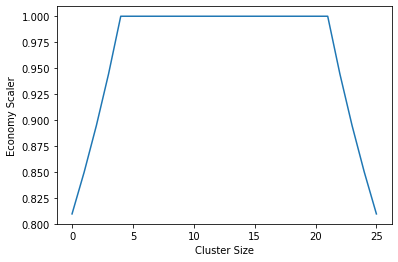

In [3]:
plt.plot(range(26),economy_scale_calcs)
plt.xlabel('Cluster Size')
plt.ylabel('Economy Scaler')
plt.show()

Our final DMoN training objective (to be minimised) is therefore the following:

$$\mathcal{L}_{\textrm{DMoN}}=\underbrace{\frac{-1}{2m} \textrm{Tr}\left(C^{\top{}}AC - C^{\top{}}\frac{dd^{\top{}}}{2m} C\right)}_{\textrm{Modularity}} + \underbrace{\left(\underbrace{\left(\frac{n - k \centerdot t}{\sum_{j=1}^k \textrm{ReLU}\left(\sum_i C_i^{\top{}} - t\right)_j}\right)}_{\textrm{Economy Scaler}}\frac{\sqrt{k}}{n} \left|\left|\sum_i C_i^{\top{}}\right|\right|_F - 1\right)}_{\textrm{Collapse Regularization}}$$

### Hierarchical DMoN
Now that we have outlined DMoN's training objective, we will explain how we will expand it to produce a hierarchical clustering as described above. Let $\hat{E} = \textrm{GCN}\left(\tilde{A}, E\right)$ be the GCN output, and $C = \textrm{softmax}\left(W\hat{E}+b\right)$ be the DMoN clustering output of $k$ clusters. We can pool the original graph using this clustering to create a new $k \times k$ adjacency matrix $A_1$ by multiplying these cluster assignments by the original adjacency matrix, i.e. $A_1 = C^{\top{}}AC$. We can created pooled features $E_1$ for these clusters similarly, also applying the SeLU activation function so that $E_1 = \textrm{SeLU}\left(C^{\top{}}\hat{E}\right)$. 

We now have an adjacency matrix and node features for this pooled graph, meaning we can apply DMoN again. Normalizing $A_1$ to get $\tilde{A}_1$, we can get a new clustering $C_1 = \textrm{softmax}\left(W_1\left(\textrm{GCN}\left(\tilde{A}_1, E_1\right)\right) + b_1\right)$ of $k_1$ clusters, where $k_1 < k$. We then repeat this process for as many levels as there are in the hierarchy. 

The diagram below, from Ying et al.'s [Hierarchical Graph Representation Learning with Differentiable Pooling](https://papers.nips.cc/paper/2018/file/e77dbaf6759253c7c6d0efc5690369c7-Paper.pdf), illustrates how a general graph pooling process works for a graph classification problem, where the graph is eventually pooled down to a single node. 

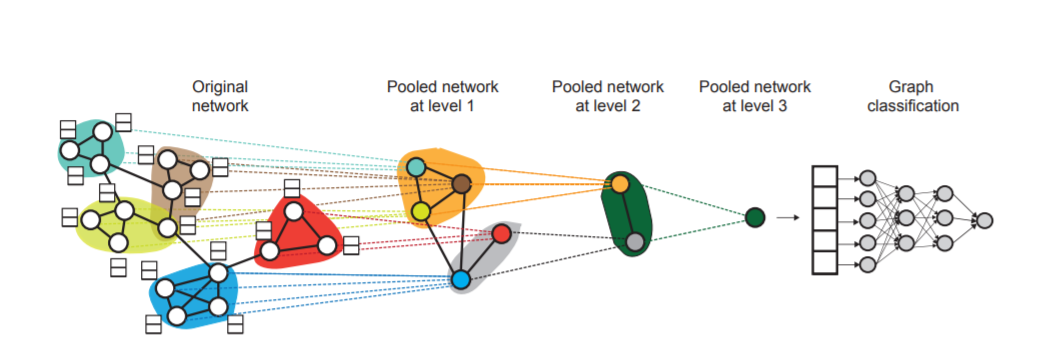

Our problem is not graph classification, so we do not need to pool down to a single node. We will apply the DMoN training objective as outlined above at every level in the hierarchy. The only adjustment we need to make is to the collapse regularization/economy scaler term; the cluster assignments matrix $C_l$ at level $l$ is a $k_{l-1} \times k_l$ matrix. However, we want to be applying the collapse regularization and economy scaling to the assignments at the most granular level of the hierarchy. Otherwise, as we get deeper in the hierarchy, the collapse regularization will only focus on the previous level at the hierarchy; a single level 1 cluster of 1,000 nodes and a single level 1 cluster of 200 nodes will be treated equally when they are being clustered at level 2. We therefore replace the assignments matrix $C_l \in \mathbb{R}^{k_{l-1} \times k_l}$ in those terms with a full assignments matrix $\hat{C}_l = \prod_{i=0}^l C_i$, so that $\hat{C}_l \in \mathbb{R}^{n \times k_l}$. Then the DMoN training objective at level $l$ is as follows:

$$\mathcal{L}_{\textrm{DMoN}}(l)=\underbrace{\frac{-1}{2m_l} \textrm{Tr}\left(C_l^{\top{}}A_lC_l - C_l^{\top{}}\frac{d_ld_l^{\top{}}}{2m_l} C_l\right)}_{\textrm{Modularity}} + \underbrace{\left(\underbrace{\left(\frac{n - k_l \centerdot t_l}{\sum_{j=1}^{k_l} \textrm{ReLU}\left(\sum_i \hat{C}_{l_i}^{\top{}} - t_l\right)_j}\right)}_{\textrm{Economy Scaler}}\frac{\sqrt{k_l}}{n} \left|\left|\sum_i \hat{C}_{l_i}^{\top{}}\right|\right|_F - 1\right)}_{\textrm{Collapse Regularization}}$$

where $l = 0$ is the input level, so that $A_0 = A$, $C_0 = C$, $d_0 = d$, $k_0 = k$, $m_0 = m$.

### Architecture
We can now describe the full architecture of our tracklist generation model. This architecture is also captured in the figure below. Let $n$ be the number of songs, $E_S$ and $E_A$ be our pre-trained song and artist embeddings of size $v$, and $X_S$ and $X_A$ be the song-song and artist-artist co-occurrence matrices used in training those embeddings. We pass these through separate GCNs to get $\hat{E}_S = \textrm{GCN}_S\left(\tilde{X}_S,E_S\right)$ and $\hat{E}_A = \textrm{GCN}_A\left(\tilde{X}_A,E_A\right)$. We then multiply $\hat{E}_A$ by the song-artist map $M$ and concatenate with $\hat{E}_S$ to get a final song embedding matrix $\hat{E} = \left[M\hat{E}_A ; \hat{E}_S\right]$, $\hat{E} \in \mathbb{R}^{n \times 2v}$.

We now input $\hat{E}$ into a Hierarchical DMoN model as described above, using $X_S$ as the adjacency matrix. In our implementation there will be three levels to the hierarchy. At the first level we get the soft clustering $C_0 = \textrm{softmax}\left(W_0\hat{E}+b_0\right)$, with pooled graph $X_1 = C_0^{\top{}} X_S C_0$ and pooled features $E_1 = \textrm{SeLU}\left(C_0^{\top{}}\hat{E}\right)$. We iterate the same process twice more to get $C_1$,$X_2$,$E_2$ and $C_2$,$X_3$,$E_3$, calculating $\mathcal{L}_{\textrm{DMoN}}(l)$ at each level as described above. We thus have three different clusterings, and, including the original, four different graphs with corresponding adjacency matrices and node feature vectors.
#### Tracklists
The model will be trained with fixed-length tracklists of length $T$, fed into the model as the indices of the songs in the tracklist. Two versions of the indices will be fed in for each tracklist: one with the first song in the tracklist at index 0, representing the target songs (to be used for teacher forcing), and one with a padding token at index 0, to be used as the input of the model. The input song indices are used to lookup vectors from $\hat{E}$, resulting in a tensor of shape (batch size, $T$, $2v$). This tensor is passed through an LSTM cell, producing a hidden state $h_i$ at each timestep $i$. The target song indices are used to lookup the soft cluster assignments $c\left(l\right)$ of the target songs at each level $l$, resulting in a tensor of size (batch size, $T$, $k_l$) at each level. These assignments are then sampled using the soft cluster probabilities for each song, producing 'hard' clusterings $\tilde{c}\left(l\right)$ for the batch. This sampling step is taken to replicate the process by which we will be generating tracklists later.

Now suppose we are trying to predict the target song at timestep $i$. We have a hidden state vector $h_i$ for that timestep, and soft clustering vectors $c\left(l\right)_i$ and hard clustering vectors $\tilde{c}\left(l\right)_i$ for the target song at each clustering level $l\in\{0,1,2\}$. We can imagine the hierarchical clustering as a truncated pyramid, with the full song population at the bottom, and the coarsest clustering at the top. The model will work its way downwards from the top of the pyramid, first predicting the coarsest cluster (i.e. the cluster at level 2) of the target song. To do this, we pass the LSTM hidden state $h_i$ through two fully connected layers to get an output vector $z_3$. To get the cluster prediction at this level, we take the level 3 graph node feature vectors $E_3$, standardize to zero mean and unit standard deviation to get $\tilde{E}_3$, and take the dot product with $z_3$, producing logits for every cluster. We then take the softmax to produce output probabilities $p_3$ for each cluster, and calculate the categorical crossentropy loss with the actual clusters $c\left(2\right)_i$. 

The process at the next level is similar. However, we now will incorporate the hard clustering vector as a teacher for the next prediction, so that the learning at each level is not dependent on predicting correctly at the level before it. Now, instead of passing the hidden state directly through the fully connected layers, we concatenate it with the hard clustering vector $\tilde{c}(2)_i$ first, before taking the same steps as previously to produce $z_2$ and take the dot product with standardized features $\tilde{E}_2$. We do the same again to make predictions at the penultimate level. At the final level, we follow the same steps up until the final output step, where instead of using the individual song embeddings $\hat{E}$ in the dot product we train a brand new fully connected softmax layer to produce probabilities $p_0$ over the 31,214 songs, and calculate sparse categorical crossentropy loss with the correct target song. 

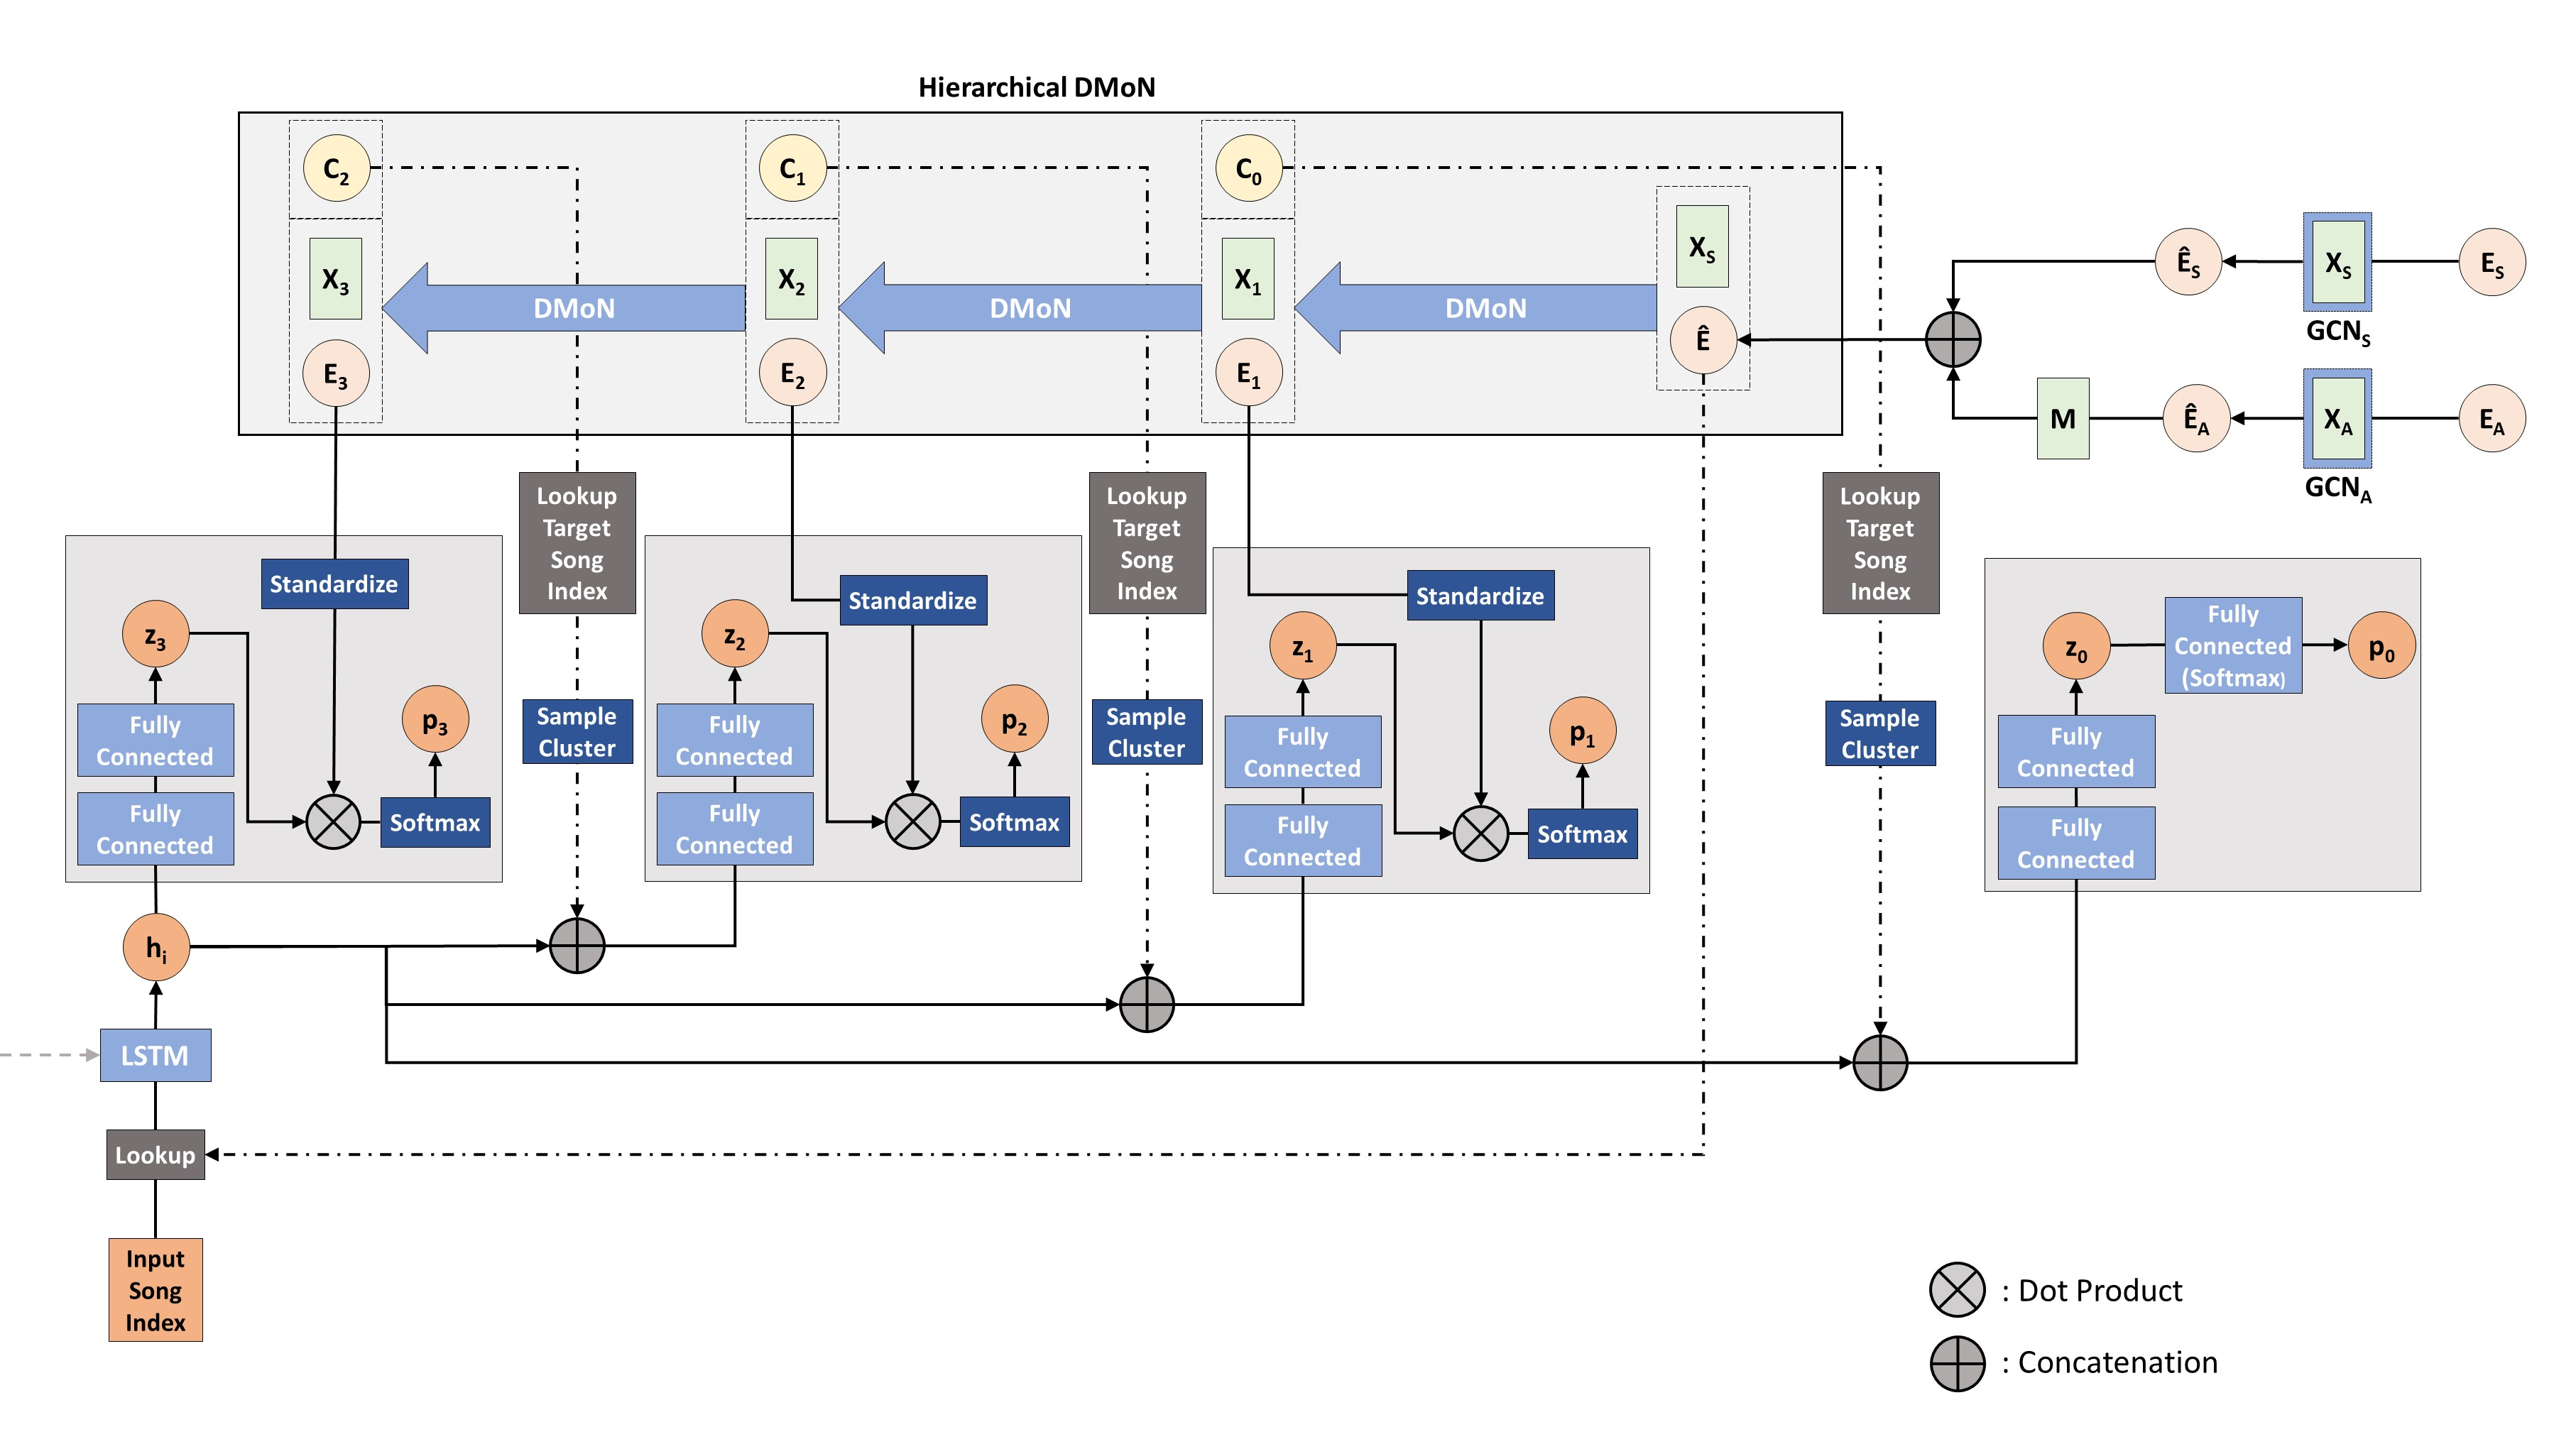

### Implementation
We will now implement the tracklist model as described above in Keras. First we need to import our song/artist embeddings and graphs, as well as the song-artist map, and convert them to tensors. We also import a couple of utility functions for dealing with graphs; these are adapted from the [DMoN repository](https://github.com/google-research/google-research/tree/master/graph_embedding/dmon).

In [4]:
song_embeds = pd.read_csv('gcn_song_embeddings_2021.csv',index_col = 0).sort_index(axis=0)
artist_embeds = pd.read_csv('gcn_artist_embeddings_2021.csv',index_col = 0)

with open('Sparse Matrices v2/song_song_sparse.pkl','rb') as f:
    song_song_sparse = pickle.load(f)

with open('Sparse Matrices v2/artist_artist_sparse.pkl','rb') as f:
    artist_artist_sparse = pickle.load(f)

with open('Sparse Matrices v2/song_artist_map_sparse.pkl','rb') as f:
    song_artist_map_sparse = pickle.load(f)
    
with open('Sparse Matrices v2/song_lst.pkl','rb') as f:
    song_lst = pickle.load(f)

with open('Sparse Matrices v2/artist_lst.pkl','rb') as f:
    artist_lst = pickle.load(f)

In [5]:
from tl_utils import convert_scipy_sparse_to_sparse_tensor,normalize_graph

In [6]:
features_tensor = K.constant(song_embeds.values)

n_nodes = song_embeds.shape[0]
graph = convert_scipy_sparse_to_sparse_tensor(song_song_sparse)
graph_normalized = convert_scipy_sparse_to_sparse_tensor(normalize_graph(song_song_sparse.copy()))

artist_features_tensor = K.constant(artist_embeds.values)
artist_graph = convert_scipy_sparse_to_sparse_tensor(artist_artist_sparse)
artist_graph_normalized = convert_scipy_sparse_to_sparse_tensor(normalize_graph(artist_artist_sparse.copy()))

song_artist_map_tensor = convert_scipy_sparse_to_sparse_tensor(song_artist_map_sparse)

#### Sequential GCN
We begin the implementation by adapting and slightly expanding the GCN implemented in [Tsitulin et al.'s DMoN repository](https://github.com/google-research/google-research/tree/master/graph_embedding/dmon). Our main change is to add the capability to take a sequence of indices as input and produce a sequence of GCN output vectors as output. 

In [7]:
class GCNSeq(tf.keras.layers.Layer):
    """Implementation of Graph Convolutional Network (GCN) layer with sequential output.

    Attributes:
    n_channels: Output dimensionality of the layer.
    norm_adjacency: Normalised graph adjacency matrix used for graph convolution.
    features: Input node features.
    skip_connection: If True, node features are propagated without neighborhood
      aggregation.
    activation: Activation function to use for the final representations.
    seq_output: Bool indicating whether or not to return sequential output based
        on input indices.
    """

    def __init__(self,
               n_channels,
               norm_adjacency,
               features,
               activation='selu',
               skip_connection = True,
                seq_output = False):
        """Initializes the layer with specified parameters."""
        super(GCNSeq, self).__init__()
        self.n_channels = n_channels
        self.skip_connection = skip_connection
        self.norm_adjacency = norm_adjacency
        self.features = features
        self.seq_output = seq_output

        if isinstance(activation, str):
            self.activation = tf.keras.layers.Activation(activation)
        elif isinstance(tf.keras.layers.Activation):
            self.activation = activation
        elif activation is None:
            self.activation = tf.keras.layers.Lambda(lambda x: x)
        else:
            raise ValueError('GCN activation of unknown type')
    

    def build(self,input_shape):
        """Builds the Keras model according to the input shape."""
        self.n_features = self.features.shape[-1]
        self.kernel = self.add_weight(
            'kernel', shape=(self.n_features, self.n_channels))
        self.bias = self.add_weight('bias', shape=(self.n_channels,))
        if self.skip_connection:
            self.skip_weight = self.add_weight(
              'skip_weight', shape=(self.n_channels,))
        else:
            self.skip_weight = 0
        super().build(input_shape)
    
    def call(self,inputs):
        """Computes GCN representations according to input features and input graph.

        Args:
          inputs: Indices of sequence input, if applicable.

        Returns:
          An (n*n_channels) node representation matrix, and sequential output if 
              seq_output is True.
        """
        norm_adjacency = self.norm_adjacency
        features = self.features

        assert len(features.shape) == 2
        assert len(norm_adjacency.shape) == 2
        assert features.shape[0] == norm_adjacency.shape[0]

        output = tf.matmul(features, self.kernel)
        if self.skip_connection:
            if isinstance(norm_adjacency, tf.SparseTensor):
                output = output * self.skip_weight + tf.sparse.sparse_dense_matmul(
                  norm_adjacency, output)
            else:
                output = output * self.skip_weight + tf.matmul(
                  norm_adjacency, output)
        else:
            if isinstance(norm_adjacency, tf.SparseTensor):
                output = tf.sparse.sparse_dense_matmul(norm_adjacency, output)
            else:
                output = tf.matmul(norm_adjacency, output)

        output = output + self.bias
        output = self.activation(output)

        if self.seq_output:
            return output,tf.nn.embedding_lookup(output,inputs)
        else:
            return output


#### Hierarchical DMoN
Next is the Hierarchical DMoN described above. This implementation is also adapted from Tsitsulin et al's repository, expanded to form the hierarchy and to implement the Economy Scaler term in the DMoN loss function(s).

In [8]:
class HierarchicalDMoN(tf.keras.layers.Layer):
    """Implementation of Hierarchical Deep Modularity Network (DMoN) layer.

    This layer builds a hierarchical clustering of the input graph by optimizing
    a modularity objective at each layer, regularized with a collapse regularization
    term and economy scaler term for eliminating small clusters.
    

    Attributes:
    adjacency: Adjacency matrix at the most granular level of the hierarchy.
    n_clusters: List of the number of clusters in the model at each level down the 
        hierarchy (largest first).
    collapse_regularization: List of collapse regularization weights to be applied
        at each level down the hierarchy.
    min_cluster_size: List of thresholds on cluster size to be used in the economy
        scaler term at each level down the hierachy. These are thresholds on the 
        number of nodes from the original graph in each cluster, not on nodes
        from the pooled graphs.
    gcn_sizes: List of n_channels for the output layer of each GCN down the 
        hierarchy.
    activation: Activation function to use for the GCNs in the hierarchy.
    skip_connection: Whether to use skip connections for each GCN in the hierarchy.
    dropout_rate: Dropout rate. Note that the dropout in applied to the
      intermediate representations before the softmax.
    do_unpooling: Parameter controlling whether to perform unpooling of the
      features with respect to their soft clusters. If true, shape of the input
      is preserved.
    """

    def __init__(self,
               adjacency,
               n_clusters,
               collapse_regularization,
               min_cluster_size,
               gcn_sizes,
               activation='selu',
               skip_connection = True,
               dropout_rate = 0,
               do_unpooling = False):
            """Initializes the layer with specified parameters."""
            super(HierarchicalDMoN, self).__init__()
            self.n_clusters = n_clusters
            self.collapse_regularization = collapse_regularization
            self.dropout_rate = dropout_rate
            self.do_unpooling = do_unpooling
            self.min_cluster_size = min_cluster_size
            self.gcn_sizes = gcn_sizes
            self.adjacency = adjacency
            
            self.number_of_nodes_full = adjacency.shape[0]
            
            assert(len(n_clusters)==len(collapse_regularization))
            assert(len(n_clusters)==len(min_cluster_size))
            assert(len(n_clusters)==len(gcn_sizes))
            
            self.skip_connection = skip_connection
            if isinstance(activation, str):
                self.activation = tf.keras.layers.Activation(activation)
            elif isinstance(tf.keras.layers.Activation):
                self.activation = activation
            elif activation is None:
                self.activation = tf.keras.layers.Lambda(lambda x: x)
            else:
                raise ValueError('GCN activation of unknown type')

    def build(self, input_shape):
        """Builds the Keras model according to the input shape."""
        #We build the transformation layer for each level in the hierarchy
        #This layer takes in the GCN output and produces the clustering logits 
        #at each level
        self.transform = [tf.keras.models.Sequential([
            tf.keras.layers.Dense(
                n_clust,
                kernel_initializer='orthogonal',
                bias_initializer='zeros'),
            tf.keras.layers.Dropout(self.dropout_rate)
        ]) for n_clust in self.n_clusters]
        
        #We then build the weights for the GCNs at the higher levels of the
        #hierarchy
        self.kernels = {}
        self.biases = {}
        self.skip_weights = {}
        for i,gcn_size in enumerate(self.gcn_sizes[:-1]):
            n_features = gcn_size
            self.kernels[i+1] = self.add_weight('kernel_%d'%(i+1), 
                                              shape=(n_features, self.gcn_sizes[i+1]))
            self.biases[i+1] = self.add_weight('bias_%d'%(i+1), 
                                             shape=(self.gcn_sizes[i+1],))
            if self.skip_connection:
                self.skip_weights[i+1] = self.add_weight(
              'skip_weight_%d'%(i+1), shape=(self.gcn_sizes[i+1],))
            else:
                self.skip_weights[i+1] = 0
        
        super(HierarchicalDMoN, self).build(input_shape)

        
    def perform_dmon(self,features,adjacency,level,
                     loss_factor,prev_assignments=None):
        """Performs DMoN clustering at a single level, and calculates the DMoN loss.
        
        Args:
            features: Node features of the graph to be clustered.
            adjacency: Adjacency matrix of the graph to be clustered.
            level: Level of the hierarchy.
            loss_factor: Scaling factor for loss function at this level for 
                controlling overall optimization behaviour of the model.
            prev_assignments: Assignments of nodes of original graph to previous 
                level of cluster. Used in calculating collapse regularization.
        Returns:
            features_pooled: Features of the pooled graph produced by the clustering.
            assignments: Results of the soft clustering at this level.
            graph_pooled: Adjacency matrix of the pooled graph produced by the 
                clustering.
        """
        assert isinstance(features, tf.Tensor) 
        assert len(features.shape) == 2
        assert len(adjacency.shape) == 2
        assert features.shape[0] == adjacency.shape[0]
        
        assignments = tf.nn.softmax(self.transform[level](features), axis=1)+1e-20
                
        cluster_sizes = tf.math.reduce_sum(assignments, axis=0)  # Size [k].
        assignments_pooling = assignments / cluster_sizes  # Size [n, k].
        
        if isinstance(adjacency, tf.SparseTensor):
            degrees = tf.sparse.reduce_sum(adjacency, axis=0)  # Size [n].
        else:
            degrees = tf.reduce_sum(adjacency, axis=0)  # Size [n].
            
        degrees = tf.reshape(degrees, (-1, 1))

        number_of_nodes = adjacency.shape[1]
        n_clusters = self.n_clusters[level]
        threshold = self.min_cluster_size[level]
        number_of_edges = tf.math.reduce_sum(degrees)

        if prev_assignments is not None:
            assignments_full = prev_assignments @ assignments
            cluster_sizes_full = tf.math.reduce_sum(assignments_full, axis=0)
            number_of_nodes_full = self.number_of_nodes_full
        else:
            assignments_full = assignments
            cluster_sizes_full = cluster_sizes
            number_of_nodes_full = number_of_nodes

        
        # Computes the size [k, k] pooled graph as C^T*X*C in two multiplications.
        if isinstance(adjacency, tf.SparseTensor):
            graph_pooled = tf.transpose(
                tf.sparse.sparse_dense_matmul(adjacency, assignments))
        else:
            graph_pooled = tf.transpose(
                tf.matmul(adjacency, assignments))
        graph_pooled = tf.matmul(graph_pooled, assignments)

        # We compute the rank-1 normaizer matrix C^T*d*d^T*C efficiently
        # in three matrix multiplications by first processing the left part C^T*d
        # and then multyplying it by the right part d^T*C.
        # Left part is [k, 1] tensor.
        normalizer_left = tf.matmul(assignments, degrees, transpose_a=True)
        # Right part is [1, k] tensor.
        normalizer_right = tf.matmul(degrees, assignments, transpose_a=True)

        # Normalizer is rank-1 correction for degree distribution for degrees of the
        # nodes in the original graph, casted to the pooled graph.
        normalizer = tf.matmul(normalizer_left,
                               normalizer_right) / 2 / number_of_edges
        spectral_loss = -tf.linalg.trace(graph_pooled -
                                         normalizer) / 2 / number_of_edges
        self.add_loss(loss_factor*spectral_loss)
        
        
        
        economy_scaler = (number_of_nodes_full-n_clusters*threshold)/ \
                                      tf.reduce_sum(tf.nn.relu(cluster_sizes_full-threshold))
        collapse_loss = economy_scaler * tf.norm(cluster_sizes_full) / number_of_nodes_full * tf.sqrt(
            float(n_clusters)) - 1
        self.add_loss(loss_factor * self.collapse_regularization[level] * \
                      collapse_loss)

        features_pooled = tf.matmul(assignments_pooling, features, transpose_a=True)
        features_pooled = tf.nn.selu(features_pooled)
        
        return features_pooled,assignments,graph_pooled
    
    def call_gcn(self,inputs,level):
        """Function for calling GCN at one level of the hierarchy.
        
        Args: 
            inputs: Tuple of (node features, normalized adjacency matrix)
                for pooled graph.
            level: Level of hierarchy
        Returns:
            GCN output"""

        features,norm_adjacency = inputs
        assert isinstance(features, tf.Tensor)
        assert len(features.shape) == 2
        assert len(norm_adjacency.shape) == 2
        assert features.shape[0] == norm_adjacency.shape[0]

        output = tf.matmul(features, self.kernels[level])
        if self.skip_connection:
            if isinstance(norm_adjacency, tf.SparseTensor):
                output = output * self.skip_weights[level] + tf.sparse.sparse_dense_matmul(
                  norm_adjacency, output)
            else:
                output = output * self.skip_weights[level] + tf.matmul(
                  norm_adjacency, output)
        else:
            if isinstance(norm_adjacency, tf.SparseTensor):
                output = tf.sparse.sparse_dense_matmul(norm_adjacency, output)
            else:
                output = tf.matmul(norm_adjacency, output)
        output = output + self.biases[level]
        
        output = self.activation(output)
                
        return output

    def standardize_graph_features(self,output):
        """Utility function for standardizing vectors to zero mean and unit 
        standard deviation
        
        Args: 
            output: vectors to be standardized
        Returns:
            Standardized vectors"""
        output_mean = tf.reduce_mean(output,axis=0)
        output_std = tf.sqrt(tf.reduce_mean(tf.square(output - output_mean),axis=0))
    
        return (output - output_mean)/output_std


    def normalize_adjacency_matrix(self,adjacency):
        """Function for normalizing the adjacency matrix of the pooled graphs.
        
        Args:
            adjacency: Graph adjacency matrix
        Returns:
            normalized: Normalized adjacency matrix
        """
        adjacency += tf.eye(adjacency.shape[0])
        degrees = tf.reduce_sum(adjacency, axis=0)  # Size [n].

        inverse_sqrt_degree = 1/tf.sqrt(degrees)
        inverse_sqrt_degree_diag = tf.linalg.diag(inverse_sqrt_degree)
        normalized = inverse_sqrt_degree_diag @ adjacency @ inverse_sqrt_degree_diag    
        return normalized
    
    def call(self, inputs):
        """Performs Hierarchical DMoN clustering.

        Args:
            inputs: A tuple of (node features, target indices).

        Returns:
            Three lists containing the soft cluster assignments at each level,
                the sequential target indices of the input sequence, and the 
                standardized pooled graph node features at each level.
        """
        features, tl_target_inds = inputs
        adjacency = self.adjacency
        
        features_pooled_1,assignments_0,graph_pooled_1 = self.perform_dmon(features,
                                                                           adjacency,0,
                                                                           loss_factor=28)
        normalized_graph_pooled_1 = self.normalize_adjacency_matrix(graph_pooled_1)
        features_pooled_1 = self.call_gcn([features_pooled_1, normalized_graph_pooled_1],
                                          level=1)
        
        features_pooled_2,assignments_1,graph_pooled_2 = self.perform_dmon(features_pooled_1,
                                                               graph_pooled_1,
                                                               1,
                                                               prev_assignments=assignments_0,
                                                               loss_factor=28)
        normalized_graph_pooled_2 = self.normalize_adjacency_matrix(graph_pooled_2)
        features_pooled_2 = self.call_gcn([features_pooled_2, normalized_graph_pooled_2],
                                          level=2)
        assignments_1_full = tf.matmul(assignments_0,assignments_1)
        
        features_pooled_3,assignments_2,graph_pooled_3 = self.perform_dmon(features_pooled_2,
                                                               graph_pooled_2,
                                                               2,
                                                               prev_assignments=assignments_1_full,
                                                               loss_factor=28)
        assignments_2_full = tf.matmul(assignments_1_full,assignments_2)
        
        assignments_seq_target_0 = tf.nn.embedding_lookup(assignments_0,tl_target_inds)
        assignments_seq_target_1 = tf.nn.embedding_lookup(assignments_1_full,tl_target_inds)
        assignments_seq_target_2 = tf.nn.embedding_lookup(assignments_2_full,tl_target_inds)
        
        features_pooled_1_normed = self.standardize_graph_features(features_pooled_1)
        features_pooled_2_normed = self.standardize_graph_features(features_pooled_2)
        features_pooled_3_normed = self.standardize_graph_features(features_pooled_3)
        
        return ((assignments_0,assignments_1_full,assignments_2_full),
                (assignments_seq_target_0,assignments_seq_target_1,assignments_seq_target_2),
                (features_pooled_1_normed,features_pooled_2_normed,features_pooled_3_normed))

#### Full model
We now use the two layers implemented above to build the full tracklist model. We first run our initial GCN to get the concatenated song and artist embedding (i.e. $\hat{E}$ above).

In [9]:
K.clear_session()

tl_inds = Input((16),dtype = tf.int32)
tl_target_inds = Input((16),dtype = tf.int32)

gcn_song_layer = GCNSeq(24,graph_normalized,features_tensor,seq_output=False)
gcn_artist_layer = GCNSeq(24,artist_graph_normalized,artist_features_tensor,
                          seq_output=False)

gcn_output_song = gcn_song_layer(tl_inds)
gcn_output_artist = gcn_artist_layer(tl_inds)

gcn_artist_mapped = Lambda(lambda x: tf.sparse.sparse_dense_matmul(
    song_artist_map_tensor,x))(gcn_output_artist)

gcn_output_concat = Concatenate(axis=-1)([gcn_artist_mapped,gcn_output_song])

gcn_seq_concat = Lambda(lambda pair: tf.nn.embedding_lookup(
    pair[0],pair[1]))((gcn_output_concat,tl_inds))

Next, we select the maximum number of clusters at each level and build the Hierarchical DMoN layer:

In [10]:
num_clusters_dict = {'level_3':48,
                    'level_2':384,
                    'level_1':1200,
                    'song_level':31214}

level_gcn_dims = {'song_level':48,'level_1':56,'level_2':64,'level_3':64}

hierarchical_dmon = HierarchicalDMoN(adjacency = graph,
                            n_clusters = [num_clusters_dict['level_1'],
                                          num_clusters_dict['level_2'],
                                          num_clusters_dict['level_3']],
                          collapse_regularization = [0.25,0.35,0.5],
                          min_cluster_size = [18,60,480],
                          gcn_sizes = [level_gcn_dims['song_level'],
                                       level_gcn_dims['level_1'],
                                       level_gcn_dims['level_2']])

dmon_out = hierarchical_dmon([gcn_output_concat,tl_target_inds])

assignments_0,assignments_1,assignments_2 = dmon_out[0]
assignments_seq_target_0,assignments_seq_target_1,assignments_seq_target_2 = dmon_out[1]
features_pooled_1,features_pooled_2,features_pooled_3 = dmon_out[2]


Now we build out the layers and parameters to be used in the tracklist part of the model.

In [11]:
level_3_dict = {}
level_2_dict = {}
level_1_dict = {}
song_level_dict = {}

level_3_dict['tanh'] = Dense(96,activation='tanh',name='level_3_tanh')
level_3_dict['selu'] = Dense(level_gcn_dims['level_3'],activation = 'selu',
                             name='level_3_selu')

level_2_dict['tanh'] = Dense(64,activation='tanh',name='level_2_tanh')
level_2_dict['selu'] = Dense(level_gcn_dims['level_2'],activation = 'selu',
                             name='level_2_selu')

level_1_dict['tanh'] = Dense(64,activation='tanh',name='level_1_tanh')
level_1_dict['selu'] = Dense(level_gcn_dims['level_1'],activation = 'selu',
                             name='level_1_selu')

song_level_dict['tanh'] = Dense(64,activation='tanh',name='song_level_tanh')
song_level_dict['selu'] = Dense(32,activation = 'selu',name='song_level_selu')
song_level_dict['softmax'] = Dense(num_clusters_dict['song_level'],
                                   activation='softmax',name='song_level_softmax')

level_dicts = {0:song_level_dict,1:level_1_dict,2:level_2_dict,3:level_3_dict}

dropout_rates = {3:0.2, 2:0.3, 1:0.35, 0:0.5}


We'll also need identity matrices at the size of n_clusters at each level.

In [12]:
id_3 = tf.constant(np.identity(num_clusters_dict['level_3']))
id_2 = tf.constant(np.identity(num_clusters_dict['level_2']))
id_1 = tf.constant(np.identity(num_clusters_dict['level_1']))

id_dict = {3:id_3,2:id_2,1:id_1}

We now define the main function for getting the prediction at each level, taking the LSTM hidden state as input.

In [13]:
def get_output(hidden,level,features_pooled=None,assignments_seq_target=None):
    """Function for getting the cluster prediction at each level. At level one
        the hidden state is passed directly through two fully connected layers.
        Otherwise, the previous level's cluster is sampled from the soft cluster 
        probabilities before it is concatenated with the hidden state. At the 
        final level, the z output is passed through another fully connected 
        layer with softmax activation to get the probabilities over the full 
        population.
        
        Args: 
            hidden: The LSTM hidden state.
            level: Level of hierarchy.
            features_pooled: Pooled feature vectors output from DMoN clustering
                at that level.
            assignments_seq_target: The soft clustering results for the target
                song index at the previous cluster
        Returns:
            Cluster/song-level probabilities"""
    level_dict = level_dicts[level]
    rate = dropout_rates[level]
    hidden = Dropout(rate = rate)(hidden)

    #If we have target indices (i.e. the level is greater than 1)
    #then we concatenate the hidden state with the sampled cluster
    if assignments_seq_target is not None:
        teacher_size = num_clusters_dict['level_%d'%(level+1)]
        
        assignments_seq_target_flat = Lambda(
            lambda x: tf.reshape(x,(-1,teacher_size)))(assignments_seq_target)
        
        assignments_seq_target_flat_log = Lambda(
            lambda x: tf.math.log(x+1e-20))(assignments_seq_target_flat)
        
        assignments_seq_target_sampled_inds = Lambda(
            lambda x: tf.random.categorical(x,1))(assignments_seq_target_flat_log)
        
        teacher_final_flat = Lambda(
            lambda x: tf.nn.embedding_lookup(id_dict[level+1],x))\
                                    (assignments_seq_target_sampled_inds)
        
        teacher_final = Lambda(
            lambda x: tf.reshape(x,(-1,16,teacher_size)))(teacher_final_flat)
        
        hidden = Concatenate(axis=-1)([hidden,teacher_final])

    h_prime = level_dict['tanh'](hidden)
    h_prime_dropped = Dropout(rate=rate)(h_prime)
    z = level_dict['selu'](h_prime_dropped)
    
    #If we are not at the song level, then we take the dot product with
    #the pooled cluster features. Otherwise, we pass through the final
    #song-level softmax
    
    if features_pooled is not None:
        z_dot = Lambda(
            lambda pair: tf.matmul(pair[0],pair[1],transpose_b=True))([z,features_pooled])
        z_dot_label = Activation('softmax')(z_dot)
        return z_dot_label
    else:
        c = level_dict['softmax'](z)
        return c

We now initialise the LSTM and build the final sequence tracklist model.

In [14]:
latent_dim = 160

lstm = LSTM(latent_dim,return_sequences=True,return_state=True,
            recurrent_dropout = 0.45,dropout = 0.4)
hidden,_,_ = lstm(gcn_seq_concat)

level_3_out = get_output(hidden,3,features_pooled_3)
level_2_out = get_output(hidden,2,features_pooled_2,assignments_seq_target_2)
level_1_out = get_output(hidden,1,features_pooled_1,assignments_seq_target_1)
pred = get_output(hidden,0,None,assignments_seq_target_0)

seq_model = Model([tl_inds,tl_target_inds],[pred,
                                            assignments_seq_target_2,
                                            assignments_seq_target_1,
                                            assignments_seq_target_0,
                                            level_3_out,
                                            level_2_out,
                                            level_1_out])

We can look at a summary of the model:

In [15]:
seq_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
gcn_seq_1 (GCNSeq)              (10322, 24)          816         input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (31214, 24)          0           gcn_seq_1[0][0]                  
__________________________________________________________________________________________________
gcn_seq (GCNSeq)                (31214, 24)          816         input_1[0][0]                    
_______________________________________________________________________________________

We are then ready to compile the model, clipping gradients to improve training stability.

In [16]:
opt = tf.keras.optimizers.Adam(3e-4,clipvalue=10)
seq_model.compile(opt)

## Training Data Setup
Now that we have built our model, we need to create and process our tracklist training data. As described above, our training data inputs to the model are the indices of the input songs and the target songs. To get the tracklist data ready for training, we also need to deal with the songs which are not in our embedding population. We will do this by replacing them with the song which has the highest cosine similarity to the embedding vector for the artist(s) which produced the tracklist. Where we do not have an embedding for the tracklist artist, we will use an average vector of all artists. We also need to produce training weights for each song in each tracklist so that the repeated artist vectors used as padding are not over-weighted. First, we import the tracklist data:

In [17]:
with open('tls_2021_processed.pkl','rb') as f:
    tracklists_dict = pickle.load(f)

### Training Set Creation
We now process the tracklist data to create the inputs for the model. We are going to split each tracklist into sub-lists of length at most 15. For tracklists longer than 15 songs, we create the sub-lists by sliding the start by 7 and taking the next 15 songs. We keep track of the original tracklist that each sub-list came from, and exclude tracklists with length less than 5.

In [18]:
tracklists = pd.DataFrame(tracklists_dict).T

tracklists_lst = tracklists.iloc[:,1].tolist()

def split_long_tl(tracklist,max_length):
    """Function for splitting long tracklists into sub-lists of fixed length.
        Slides by half the tracklist length at each split.
        
        Args:
            tracklist: Original full-length tracklist 
            max_length: Size of sub-lists to be created
        Returns:
            List of sub-lists created"""
    if len(tracklist) <= max_length:
        return [tracklist]
    else:
        step = max_length//2
        out = []
        num_out = len(tracklist)//step
        for i in range(num_out):
            out.append(tracklist[step*i:step*i+max_length])
        return out

tracklists['Split'] = tracklists['Tracks'].apply(lambda x:split_long_tl(x,15))

tracklists_int = []
for i,tracklist in enumerate(tracklists_lst):
    tl_split = tracklists.iloc[i,:].loc['Split']
    tracklists_int += [(i,tl) for tl in tl_split if len(tl) >= 5]

We now calculate the closest song for each tracklist artist, for replacing the songs not in our population. We first need to get the embedding representations for the artist of each tracklist; if there are multiple artists, we take the average of their embeddings. If the artist is not in our embedding population, we use the average across all artist embeddings instead.

In [19]:
avg_vec_artist = artist_embeds.mean(axis = 0).values


def get_avg_embed_artist(artists_lst):
    """Function for calculating the average embedding of a list of artists.
        If any of the artists are not in the embedding population, then the 
        average across all artist embeddings is returned instead.
        
        Args:
            artists_lst: list of artists
                
        Returns:
            avg_vec_artist: average embedding vector of artists list"""
    if artists_lst == []:
        return avg_vec_artist
    try:
        embeds = artist_embeds.loc[artists_lst,:].values
        return np.mean(embeds,axis = 0)
    except:
        return avg_vec_artist

tracklist_artist_lst = tracklists.iloc[:,2].tolist()
tracklist_artist_embeds = np.array([get_avg_embed_artist(artist_lst) for artist_lst in tracklist_artist_lst])

We now take the cosine similarity of these artist vectors with the song embeddings. This will be well-defined because of our training process to generate these embeddings, which involved training against matrix factorisation loss of the product of these two embeddings against the song-artist co-occurrence matrix. We do this in chunks to avoid memory issues.

In [20]:
num_artist_embeds = tracklist_artist_embeds.shape[0]
chunk_size = 10000
num_chunks = num_artist_embeds//chunk_size + 1

artist_closest_songs = []

for chunk in range(num_chunks):
    song_artist_dist = cosine_similarity(
        tracklist_artist_embeds[chunk*chunk_size:(chunk+1)*chunk_size],
        song_embeds.values)
    artist_closest_song_chunk = np.argmax(song_artist_dist,axis=1)
    artist_closest_songs.append(artist_closest_song_chunk)
    del song_artist_dist
    
artist_closest_song = np.concatenate(artist_closest_songs,axis=0)

We take a look at the value counts of the closest songs to identify which song index is associated with the average artist vector - this will need to be weighted down in the model training process.

In [21]:
highest_count_songs = pd.Series(artist_closest_song).value_counts().iloc[:10]
average_replacement = highest_count_songs.index[0]
highest_count_songs

16210    20414
17631      586
165        569
26075      473
29803      416
29578      414
4095       377
10269      367
6961       362
16302      342
dtype: int64

We now create the main training set. After building a map from song title to indices in the song list, we build a function which takes a tracklist and returns the inputs for our model, as well as weights on the training examples.

In [22]:
song_embeds_index_map = {}
for i,song in enumerate(song_lst):
    song_embeds_index_map[song] = i

In [23]:
def get_tl_inds(tracklist_ind,tl):
    """Function for creating index inputs for generator model, along with
        weights for each training example. The closest song to the tracklist artist
        is used to replace songs not in our population, and as padding to reach the 
        max tracklist length. Weights are 1 for songs in the population, 0.1 for 
        the replacements, and 0.001 for padding or if the replacement song is the 
        average artist vector.
        
        Args:
            tracklist_ind: index of the Tracklist in the split tracklist list
            tl: Songs titles from the tracklist
                
        Returns:
            inds_input: The song indices to be used as input for the model
            inds_target: The song indices to be used as targets for prediction in the model. 
                These are the same as the input inds but shifted back one song.
            weights: The weights of each training example"""
    closest_song_ind = artist_closest_song[tracklist_ind]
    inds = []
    weights = []
    for song in tl:
        try:
            inds.append(song_embeds_index_map[song])
            weights.append(1)
        except KeyError:
            inds.append(closest_song_ind)
            if closest_song_ind == average_replacement:
                weights.append(0.001)
            else:
                weights.append(0.1)
    length = len(inds)
    if length < 15:
        inds += [closest_song_ind for _ in range(15-length)]
    weights += [0.001 for _ in range(16-length)]
    inds_input = [closest_song_ind]+inds
    inds_target = inds+[closest_song_ind]
    return inds_input,inds_target,weights

inds_input,inds_target,weights = list(zip(*[get_tl_inds(*pair) for pair in tracklists_int]))

We will need to filter this dataset to remove tracklists which mostly consist of songs that are not in our population. We will remove any tracklists where less than half the songs are in our population, or where there are less than 5 pairs of consecutive songs in our population. This leaves us with a total of 105,275 tracklists in our training data.

In [24]:
song_set = set(song_lst)

pair_counts = []
counts = []
for pair in tracklists_int:
    incl = [x in song_set for x in pair[1]]
    counts.append(incl.count(True))
    pairs = [(incl[i],incl[i+1]) for i in range(len(incl)-1)]
    pair_counts.append(pairs.count((True,True)))
    
tl_keep = [i for i in range(len(counts)) if counts[i]>7 or pair_counts[i]>4]    
print('Number of tracklists in training data: ',len(tl_keep))

Number of tracklists in training data:  105275


In [25]:
training_inds_input = np.array(inds_input)[tl_keep]
training_weights = np.stack(np.array(weights)[tl_keep])
training_inds_target = np.array(inds_target)[tl_keep]

### Train-validation split
To split the training examples into a training set and a validation set, we will need to make sure that we take into account the original tracklist that the sub-lists came from; otherwise, since we split the tracklists with a sliding window, there may be some overlap between training set examples and validation set examples. We therefore sample a validation set from the original tracklist indices, and use that to create the training and validation sets.

In [26]:
tl_full_keep = [tracklists_int[i][1] for i in tl_keep]
tl_inds_keep = [tracklists_int[i][0] for i in tl_keep]

tl_inds_keep_unique = list(set(tl_inds_keep))

In [27]:
random.seed(1)
vad_tl_inds = random.sample(tl_inds_keep_unique,1000)

vad_inds = [i for i in range(len(tl_inds_keep)) if tl_inds_keep[i] in vad_tl_inds]
train_inds = [i for i in range(len(tl_inds_keep)) if tl_inds_keep[i] not in vad_tl_inds]

train_set_inputs = training_inds_input[train_inds]
vad_set_inputs = training_inds_input[vad_inds]


train_set_targets = training_inds_target[train_inds]
vad_set_targets = training_inds_target[vad_inds]


train_set_weights = training_weights[train_inds]
vad_set_weights = training_weights[vad_inds]

train_set_tls = [tl_full_keep[i] for i in train_inds]
vad_set_tls = [tl_full_keep[i] for i in vad_inds]

In [28]:
print('Training set size: ', train_set_inputs.shape[0])
print('Validation set size: ', vad_set_inputs.shape[0])

Training set size:  103168
Validation set size:  2107


## Model Training
We are now ready to run the main training loop for the model. First we initialise the accuracy metric objects for each level of the hierarchy, and create a shortcut function for resetting their states.

In [29]:
level_3_acc = tf.keras.metrics.CategoricalAccuracy()
level_2_acc = tf.keras.metrics.CategoricalAccuracy()
level_1_acc = tf.keras.metrics.CategoricalAccuracy()
song_level_acc = tf.keras.metrics.SparseCategoricalAccuracy()


def reset_accs():
    """Function for resetting the states of the accuracy metrics
    used in monitoring the model."""
    
    level_3_acc.reset_states()
    level_2_acc.reset_states()
    level_1_acc.reset_states()
    song_level_acc.reset_states()

Now we can implement the function which performs one step of training. This function calculates the total loss from DMoN as well as the crossentropy losses in predicting the tracklist cluster at each level of the hierarchy, before applying gradient updates and updating the categorical accuracy metrics.

In [30]:
@tf.function
def train_step(model,inputs,targets,weights):
    """tf.function for applying gradient updates to the model and calculating
        metrics.
        
        Args:
            model: Keras model to update
            inputs: Model inputs used to calculate losses for gradient descent
            targets: Targets for calculting additional crossentropy loss
            weights: Sample weights for training examples
                
        Returns:
            List of model's losses"""
    
    with tf.GradientTape() as tape:
        song_level_out,\
        assignments_seq_target_2,\
        assignments_seq_target_1,\
        assignments_seq_target_0,\
        level_3_out,\
        level_2_out,\
        level_1_out = model(inputs, training=True)
        
        level_3_loss = tf.keras.losses.CategoricalCrossentropy()(
            assignments_seq_target_2,level_3_out,
            sample_weight = weights)
        
        level_2_loss = tf.keras.losses.CategoricalCrossentropy()(
            assignments_seq_target_1,level_2_out,
            sample_weight = weights)
        
        level_1_loss = tf.keras.losses.CategoricalCrossentropy()(
            assignments_seq_target_0,level_1_out,
            sample_weight = weights)
        
        song_level_loss = tf.keras.losses.SparseCategoricalCrossentropy()(
            targets,song_level_out,
            sample_weight = weights)

        dmon_loss_value = sum(model.losses)
        total_loss = dmon_loss_value + level_3_loss + level_2_loss + \
            level_1_loss + song_level_loss
    
    grads = tape.gradient(total_loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    level_3_acc.update_state(assignments_seq_target_2,level_3_out,
            sample_weight = weights)
    
    level_2_acc.update_state(assignments_seq_target_1,level_2_out,
            sample_weight = weights)
    
    level_1_acc.update_state(assignments_seq_target_0,level_1_out,
            sample_weight = weights)
    
    song_level_acc.update_state(
            targets,song_level_out,
            sample_weight = weights)

    return model.losses+[level_3_loss,level_2_loss,level_1_loss,song_level_loss]

Finally, we set up a few preliminaries for monitoring performance on the validation set, and check the status of the clustering using a Keras model which returns the soft clustering learned by our main model.

In [31]:
def get_validation_losses(vad_set_inputs,vad_set_targets,vad_set_weights):
    """Function for calulating validation losses at each level of the 
        hierarchy and updating validation accuracy metrics.
        
        Args:
            vad_set_inputs: Model inputs used to calculate validation 
                losses for gradient descent.
            vad_set_targets: Targets for calculting additional 
                crossentropy loss on validation set.
            vad_set_weights: Sample weights for validation examples.
                
        Returns:
            List of validation losses"""
    
    song_level_out,\
    assignments_seq_target_2,\
    assignments_seq_target_1,\
    assignments_seq_target_0,\
    level_3_out,\
    level_2_out,\
    level_1_out = seq_model([vad_set_inputs,vad_set_targets],training=False)

    level_3_loss = tf.keras.losses.CategoricalCrossentropy()(
        assignments_seq_target_2,level_3_out,
        sample_weight = vad_set_weights)

    level_2_loss = tf.keras.losses.CategoricalCrossentropy()(
        assignments_seq_target_1,level_2_out,
        sample_weight = vad_set_weights)

    level_1_loss = tf.keras.losses.CategoricalCrossentropy()(
        assignments_seq_target_0,level_1_out,
        sample_weight = vad_set_weights)

    song_level_loss = tf.keras.losses.SparseCategoricalCrossentropy()(
        vad_set_targets,song_level_out,
        sample_weight = vad_set_weights)
    
    level_3_acc.update_state(assignments_seq_target_2,level_3_out,
            sample_weight = vad_set_weights)
    
    level_2_acc.update_state(assignments_seq_target_1,level_2_out,
            sample_weight = vad_set_weights)
    
    level_1_acc.update_state(assignments_seq_target_0,level_1_out,
            sample_weight = vad_set_weights)
    
    song_level_acc.update_state(
            vad_set_targets,song_level_out,
            sample_weight = vad_set_weights)
    
    return [level_3_loss.numpy(),level_2_loss.numpy(),
            level_1_loss.numpy(),song_level_loss.numpy()]

In [32]:
num_vad_examples = vad_set_inputs.shape[0]
vad_batch_size = num_vad_examples//5

def get_validation_results():
    """Function for running the evaluation of the validation set.
    
    Returns:
        Average losses and accuracies for the validation set."""
    
    vad_losses = []
    vad_accs = []
    for batch in range(num_vad_examples//vad_batch_size):
        vad_loss = get_validation_losses(
            vad_set_inputs[batch*vad_batch_size:(batch+1)*vad_batch_size], 
             vad_set_targets[batch*vad_batch_size:(batch+1)*vad_batch_size],
             vad_set_weights[batch*vad_batch_size:(batch+1)*vad_batch_size])

        vad_acc = [level_3_acc.result().numpy(),level_2_acc.result().numpy(),
                level_1_acc.result().numpy(),song_level_acc.result().numpy()]

        vad_losses.append(vad_loss)
        vad_accs.append(vad_acc)
    
    reset_accs()
    return np.mean(np.array(vad_losses),axis=0).tolist(),\
            np.mean(np.array(vad_accs),axis=0).tolist()

In [33]:
assignments_model = Model([tl_inds,tl_target_inds],[assignments_0,assignments_1,assignments_2])

def get_clusters(assignments_pred):
    """Function which takes soft clustering assignments and allocates
        each song to its argmax.
        
        Args:
            assignments_pred: soft clustering assignment probabilities
            
        Returns:
            Assigned clustering.
        """
    
    return pd.Series(np.argmax(assignments_pred,axis=-1))

We also create separate Keras models to extract the cluster predictions at each level, the GCNs for song and artist, and the pooled features at each level of the hierarchy. This is to make it easier to save checkpoints of the model into separate pieces.

In [34]:
level_models = {}

hidden_input = Input((1,160))

cluster_sizes_final = [num_clusters_dict['level_1'],
                          num_clusters_dict['level_2'],
                          num_clusters_dict['level_3']]



for level in range(4):
    level_dict = level_dicts[level]
    if level < 3:
        teacher_input = Input((1,cluster_sizes_final[level]))
        hidden_concat = Concatenate(axis=-1)([hidden_input,teacher_input])
    else:
        hidden_concat = Lambda(lambda x: x)(hidden_input)
        
    h_prime = level_dict['tanh'](hidden_concat)
    d = level_dict['selu'](h_prime)
    if level == 0:
        c = level_dict['softmax'](d)
        level_models[level] = Model([hidden_input,teacher_input],c)
    elif level == 3:
        level_models[level] = Model(hidden_input,d)
    else:
        level_models[level] = Model([hidden_input,teacher_input],d)

In [35]:
single_tl_ind = Input((1),dtype = tf.int32)
gcn_song_single = gcn_song_layer(single_tl_ind)

gcn_artist_single = gcn_artist_layer(single_tl_ind)
gcn_artist_single_mapped = Lambda(lambda x: tf.sparse.sparse_dense_matmul(
    song_artist_map_tensor,x))(gcn_artist_single)


gcn_single_concat = Concatenate(axis=-1)([gcn_artist_single_mapped,gcn_song_single])

gcn_single_lookup = Lambda(lambda pair: tf.nn.embedding_lookup(
    pair[0],pair[1]))((gcn_single_concat,single_tl_ind))


state_h_input = Input(shape = (latent_dim))
state_c_input = Input(shape = (latent_dim))

hidden_single,state_h,state_c = lstm(gcn_single_lookup,
                                     initial_state=[state_h_input,state_c_input])

lstm_model = Model([single_tl_ind,state_h_input,state_c_input],
                   [hidden_single,state_h,state_c])


In [36]:
features_model = Model([tl_inds,tl_target_inds],
                       [features_pooled_1,features_pooled_2,features_pooled_3])

In [37]:
def save_model_weights(assignments_all):
    """Function which saves the various weights and outputs of
        the tracklist model, including:
            The hierarchical DMoN weights,
            the weights for predicting the cluster at each level of
                the hierarchy,
            the LSTM,
            the pooled features of the graphs in the hierarchy,
            the clustering assignments,
            and the training and validation loss/accuracy history.
    """
    dmon_weights = {}
    for x in hierarchical_dmon.variables:
        dmon_weights[x.name.split('/')[-1].split(':')[0]] = x.numpy()
    with open('graph_hierarchy_models/Sampled 2021 v2/dmon_weights.pkl','wb') as f:
        pickle.dump(dmon_weights,f)
        
    level_dict_weights = {}
    for level in level_dicts:
        level_dict_weights[level] = {}
        for layer in level_dicts[level]:
            level_dict_weights[level][layer] = level_dicts[level][layer].get_weights()
            
    level_dict_weights['lstm'] = lstm.get_weights()
    level_dict_weights['gcn'] = gcn_song_layer.get_weights()
    level_dict_weights['gcn_artist'] = gcn_artist_layer.get_weights()
    
    with open('graph_hierarchy_models/Sampled 2021 v2/level_dict_weights.pkl','wb') as f:
        pickle.dump(level_dict_weights,f)
        
    for level in level_models:
        level_models[level].save('graph_hierarchy_models/Sampled 2021 v2/level_%d_model'%level)
        
    lstm_model.save('graph_hierarchy_models/Sampled 2021 v2/lstm_model')
    
    features_pred_all = features_model.predict([vad_set_inputs[[0]],vad_set_targets[[0]]],batch_size=1)
    with open('graph_hierarchy_models/Sampled 2021 v2/features_pred_all.pkl','wb') as f:
        pickle.dump(features_pred_all,f)
    
    assignments_1,assignments_2,assignments_3 = assignments_all
    assignments_df_1 = pd.DataFrame(assignments_1,index=song_embeds.index)
    assignments_df_2 = pd.DataFrame(assignments_2,index=song_embeds.index)
    assignments_df_3 = pd.DataFrame(assignments_3,index=song_embeds.index)

    assignments_df_1.to_csv('graph_hierarchy_models/Sampled 2021 v2/assignments_df_1.csv')
    assignments_df_2.to_csv('graph_hierarchy_models/Sampled 2021 v2/assignments_df_2.csv')
    assignments_df_3.to_csv('graph_hierarchy_models/Sampled 2021 v2/assignments_df_3.csv')
    
    with open('graph_hierarchy_models/Sampled 2021 v2/training_history.pkl','wb') as f:
        pickle.dump(training_history,f)
    with open('graph_hierarchy_models/Sampled 2021 v2/vad_history.pkl','wb') as f:
        pickle.dump(vad_history,f)


### Training Loop
We can now run the training loop. A single epoch runs through the full training set data in batches of size 500. For every epoch, we log to a text file the model's DMoN losses (Modularity and Collapse Regularization) as well as the crossentropy losses, accuracies and time; each epoch takes about 6 minutes. Although we calculate it at every epoch, to improve readability we only log the validation set information to the main logging file every 25 epochs, along with the number of active clusters at each level in the hierarchy. We log the validation information at each epoch to a separate validation text file. We also save a checkpoint of the model every 50 epochs.

In [38]:
num_epochs = 750
batch_size = 500
ckpt_frequency = 50
num_training_examples = train_set_inputs.shape[0]

training_history = []
vad_history = []
logging_file = 'logging_20210713.txt'
vad_logging_file = 'logging_vad_20210713.txt'

In [39]:
def run_training_loop(epoch_start_num,num_epochs):
    """Function which runs the main training loop.
    
        Args:
            epoch_start_num: The number of the first epoch index
                for logging purposes. To be used if running
                the training loop more than once.
            num_epochs: The number of epochs to run for.
    """    
    for epoch in range(epoch_start_num,epoch_start_num+num_epochs):
        start_epoch = time.time()
        shuffled_inds = random.sample(range(num_training_examples),num_training_examples)
        epoch_losses = []
        for batch in range(num_training_examples//batch_size):
            inputs_batch = train_set_inputs[shuffled_inds[batch*batch_size:(batch+1)*batch_size]]        
            targets_batch = train_set_targets[shuffled_inds[batch*batch_size:(batch+1)*batch_size]]
            weights_batch = train_set_weights[shuffled_inds[batch*batch_size:(batch+1)*batch_size]]

            loss_values = train_step(seq_model,[inputs_batch,targets_batch],targets_batch,
                                     weights_batch)
            epoch_losses.append([x.numpy() for x in loss_values])

        avg_losses = np.mean(np.array(epoch_losses),axis=0)
        dmon_losses = avg_losses[:6]
        crossentropy_losses = avg_losses[6:]

        accs = [level_3_acc.result().numpy(),level_2_acc.result().numpy(),
                level_1_acc.result().numpy(),song_level_acc.result().numpy()]

        training_history.append((avg_losses,accs))
        logging_str = ' '.join(
            [f'epoch {epoch+1} DMoN: '+' '.join([f'{x:.4f}' for x in dmon_losses]),'\t',
              'CE: '+' '.join([f'{x:.4f}' for x in crossentropy_losses[::-1]]),'\n \t',
              '  accs: '+' '.join([f'{acc:.4f}' for acc in accs[::-1]]),'\t', 
              ' time: ',str(np.round(time.time()-start_epoch)),'s'])
        #print(logging_str)

        with open(logging_file, 'a') as f:
            f.write(logging_str+'\n')

        reset_accs()

        vad_losses,vad_accs = get_validation_results()
        vad_history.append((vad_losses,vad_accs))
        vad_str = ' '.join([f'epoch {epoch+1} validation' + '\t' + 'CE:',
                                ' '.join([f'{x:.4f}' for x in vad_losses[::-1]]),'\t',
                 ' accs: ', ' '.join([f'{x:.4f}' for x in vad_accs[::-1]])])

        with open(vad_logging_file, 'a') as f:
            f.write(vad_str+'\n')

        if (epoch+1)%25 == 0:
            assignments_all = assignments_model.predict([vad_set_inputs[[0]],
                                                         vad_set_targets[[0]]],
                                                        batch_size=1)

            clusters_all = [get_clusters(pred) for pred in assignments_all]
            vad_str_full = ' '.join([vad_str,'\n'+
                 'Cluster Sizes: ',',  '.join(['Level %d: '%(i+1)+\
                                                str(len(clusters.value_counts()))
                                                for i,clusters in enumerate(clusters_all)])])
            #print(vad_str)
            with open(logging_file, 'a') as f:
                f.write(vad_str_full+'\n')
        if (epoch+1)%ckpt_frequency == 0:
            print('Saving checkpoint at epoch',epoch+1)
            save_model_weights(assignments_all)
            


In [40]:
run_training_loop(0,num_epochs)

We can read in the logging file and print the results every 50 epochs to show how the training loss changed over time.

In [41]:
log_file = open(logging_file)

lines = log_file.read()
lines_lst = lines.split('\n')
for i,line in enumerate(lines_lst):
    if 'epoch' in line:
        epoch_num = int(line.split()[1])
        if epoch_num == 1 or epoch_num % 50 == 0:
            print(line)
            print(lines_lst[i+1])
log_file.close()

epoch 1 DMoN: -0.0059 0.0069 -0.0202 -1.5302 -0.2531 -5.3349 	 CE: 6.9494 4.9288 4.1521 2.3640 
 	   accs: 0.0011 0.1241 0.7770 0.2946 	  time:  376.0 s
epoch 50 DMoN: -1.5995 -0.4503 -2.6377 -2.3421 -7.0824 -5.2016 	 CE: 3.2356 1.1983 1.4569 1.0486 
 	   accs: 0.0613 0.4778 0.3981 0.5372 	  time:  354.0 s
epoch 50 validation	CE: 2.9918 1.1009 1.4083 1.0087 	  accs:  0.0777 0.5165 0.3987 0.5506 
Cluster Sizes:  Level 1: 1094,  Level 2: 313,  Level 3: 22
epoch 100 DMoN: -1.8059 -0.5857 -2.8178 -2.3417 -7.1367 -5.2108 	 CE: 2.5475 0.7963 1.3277 1.0336 
 	   accs: 0.0900 0.5249 0.4170 0.5413 	  time:  356.0 s
epoch 100 validation	CE: 2.4100 0.7088 1.2914 0.9974 	  accs:  0.1030 0.5820 0.4173 0.5492 
Cluster Sizes:  Level 1: 1079,  Level 2: 313,  Level 3: 22
epoch 150 DMoN: -1.8292 -0.5953 -2.8284 -2.3433 -7.1389 -5.2108 	 CE: 2.4280 0.7540 1.3069 1.0296 
 	   accs: 0.1059 0.5342 0.4219 0.5429 	  time:  355.0 s
epoch 150 validation	CE: 2.3073 0.6713 1.2774 0.9950 	  accs:  0.1240 0.5935 0.

We can also plot the model's losses throughout training to examine convergence behaviour.

In [42]:
level_titles = ['Level 3','Level 2','Level 1','Song Level']
    
training_history_losses = [x[0] for x in training_history]
training_history_accs = [x[1] for x in training_history]

vad_history_losses = [x[0] for x in vad_history]
vad_history_accs = [x[1] for x in vad_history]

training_history_loss_arr = np.stack(training_history_losses)
vad_history_loss_arr = np.stack(vad_history_losses)

training_history_accs_arr = np.array(training_history_accs)
vad_history_accs_arr = np.array(vad_history_accs)

training_history_dmon = training_history_loss_arr[:,:6]

First we plot the DMoN modularity loss and collapse regularization at each level. Note the almost stepwise jumps in the collapse regularization at Level 1 and Level 2: these correspond to the model eliminating a cluster which is below the minimum size threshold in the economy scaler term.

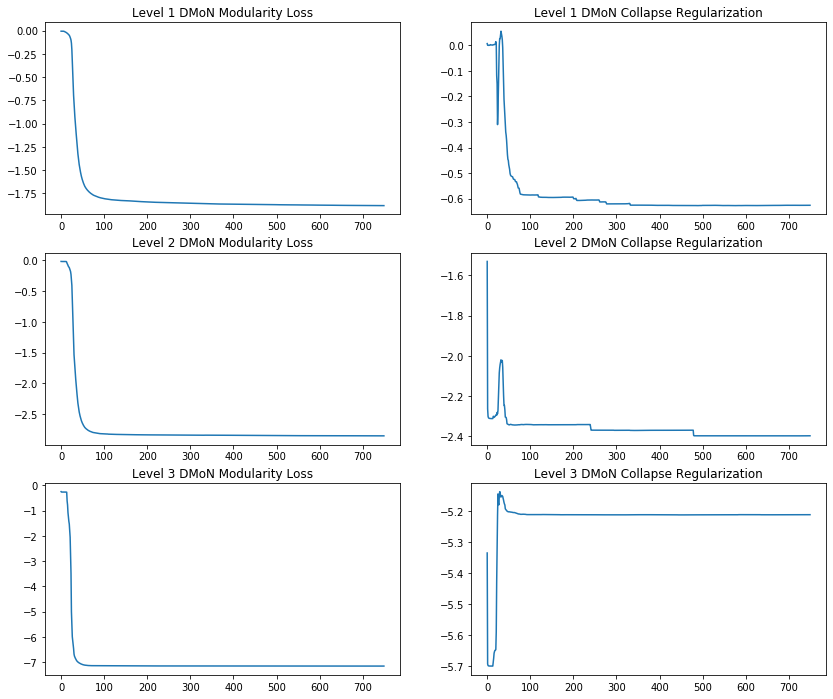

In [43]:
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(nrows=3, ncols=2)

for i in range(3):
    ax0 = fig.add_subplot(gs[i, 0])
    ax0.plot(range(len(training_history_dmon)),training_history_dmon[:,2*i])
    ax0.set_title('%s DMoN Modularity Loss'%level_titles[2-i])
    
    ax0 = fig.add_subplot(gs[i, 1])
    ax0.plot(range(len(training_history_dmon)),training_history_dmon[:,2*i+1])
    ax0.set_title('%s DMoN Collapse Regularization'%level_titles[2-i])

plt.show()

We plot the cross-entropy training and validation loss/accuracy at each level. Keras calculates the training loss with dropout included, which is why it is higher than the validation loss. We exclude the first 25 epochs because this was before the DMoN clustering had started to converge, meaning the cross-entropy was highly volatile.

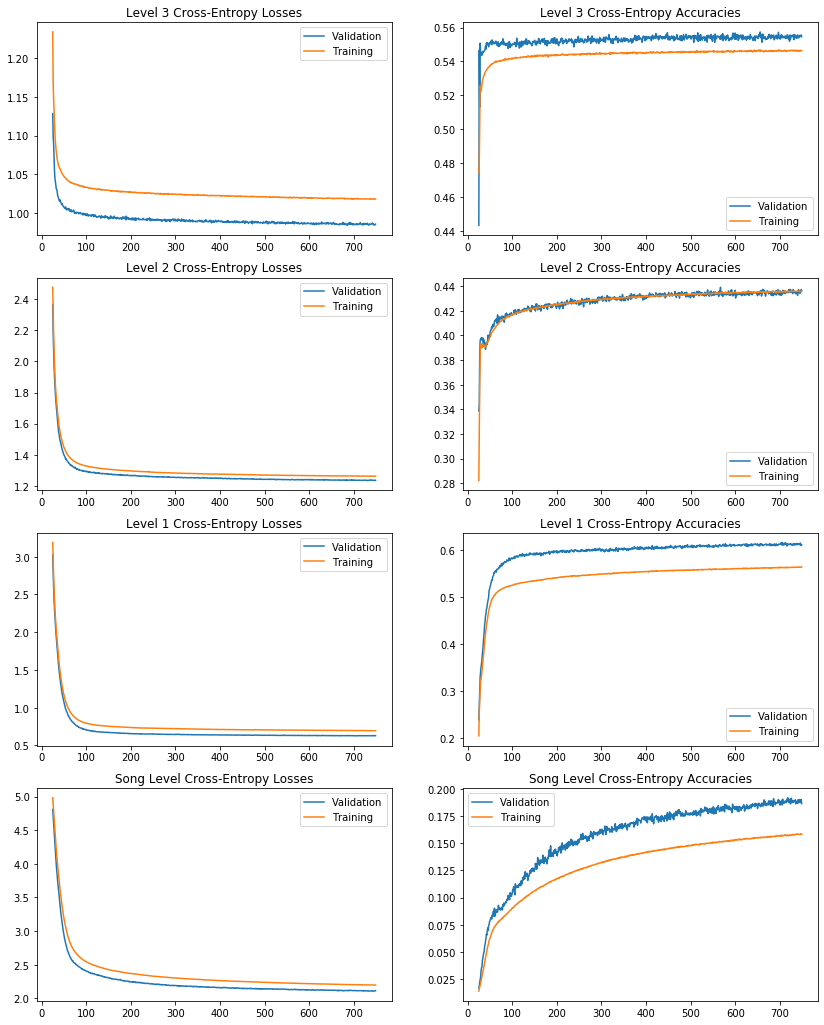

In [44]:
fig = plt.figure(figsize=(14, 18))
gs = gridspec.GridSpec(nrows=4, ncols=2,hspace = 0.2)

for i in range(4):
    ax0 = fig.add_subplot(gs[i, 0])
    ax0.plot(range(25,len(vad_history_loss_arr)),vad_history_loss_arr[25:,i],label = 'Validation')
    ax0.plot(range(25,len(training_history_loss_arr)),training_history_loss_arr[25:,6+i],label = 'Training')

    ax0.set_title('%s Cross-Entropy Losses'%level_titles[i])
    ax0.legend()
    
    ax0 = fig.add_subplot(gs[i, 1])
    ax0.plot(range(25,len(vad_history_accs_arr)),vad_history_accs_arr[25:,i],label = 'Validation')
    ax0.plot(range(25,len(training_history_accs_arr)),training_history_accs_arr[25:,i],label = 'Training')
    ax0.set_title('%s Cross-Entropy Accuracies'%level_titles[i])
    ax0.legend()


plt.show()

The model is now ready to be used to generate tracklists. This is done in the [Recommendation notebook](4.%20Recommendation.ipynb).